Dataset used: "https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset"

In [ ]:
! pip install seaborn
! pip install virtualenv
! pip install seaborn
! pip install tensorflow
! pip install xlwt

## Importing Modules and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import virtualenv as venv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from tqdm import tqdm
from dataclasses import dataclass
import time
from scipy.optimize import minimize, Bounds
# from svm_utils import *
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import chi2
from collections import Counter

In [2]:
data_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
df = pd.read_csv(data_link)

## Exploratory Data Analysis

In [3]:
# Getting rid of duplicates
df = df.drop_duplicates()

In [4]:
#separating numerical and categorical variables
df_num = df[['Administrative', 'Administrative_Duration', 'Informational',
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
             'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']]

df_cat = df[['Month', 'OperatingSystems', 'Browser',
             'Region', 'TrafficType', 'VisitorType',
             'Weekend', 'Revenue']]

# separating classes
df_true = df.loc[df['Revenue'] == True]
df_false = df.loc[df['Revenue'] == False]

#encoding target variable for splitting data
"""
1. if using Naive Bayes, Logistic Regression, Neural Networks -> classes = 0 and 1.
2. if using SVM -> classes = -1 and +1.
"""


'\n1. if using Naive Bayes, Logistic Regression, Neural Networks -> classes = 0 and 1.\n2. if using SVM -> classes = -1 and +1.\n'

In [5]:
print(df.describe()) #gives the descriptive stats for numerical features

       Administrative  Administrative_Duration  Informational  \
count    12205.000000             12205.000000   12205.000000   
mean         2.338878                81.646331       0.508726   
std          3.330436               177.491845       1.275617   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 9.000000       0.000000   
75%          4.000000                94.700000       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12205.000000    12205.000000             12205.000000   
mean                34.825454       32.045637              1206.982457   
std                141.424807       44.593649              1919.601400   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        8.00000

In [6]:
#checking categories in each column
print("The no. of categories in each categorical feature are: \n\n",df_cat.nunique())

The no. of categories in each categorical feature are: 

 Month               10
OperatingSystems     8
Browser             13
Region               9
TrafficType         20
VisitorType          3
Weekend              2
Revenue              2
dtype: int64


In [7]:
print("The size of the dataset is: \nRecords: {}\nFeatures: {}\n".format(df.shape[0], df.shape[1]))
df.info()

The size of the dataset is: 
Records: 12205
Features: 18

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region            

In [8]:
#converting data type of each categorica variable to integer,
# df['SpecialDay']= df['SpecialDay'].astype(int)
df['OperatingSystems']= df['OperatingSystems'].astype(int)
df['Browser']= df['Browser'].astype(int)
df['Region']= df['Region'].astype(int)
df['TrafficType']= df['TrafficType'].astype(int)

In [9]:
# LabelEncoding the target variable
boolmap = {True: 1, False : 0}
df['Weekend'] = df['Weekend'].map(boolmap)
df['Revenue']=df['Revenue'].map(boolmap)

#One-hot encoding 'Month' and 'VisitorType' Feature
df = pd.get_dummies(df, columns=["Month", 'VisitorType'], prefix=["Month_", 'Visitor_'], dtype=float)

df_cat = df[['OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Weekend', 'Revenue', 'Month__Aug', 'Month__Dec', 'Month__Feb',
       'Month__Jul', 'Month__June', 'Month__Mar', 'Month__May', 'Month__Nov',
       'Month__Oct', 'Month__Sep', 'Visitor__New_Visitor', 'Visitor__Other', 'Visitor__Returning_Visitor']]

The percentage of each class in the dataset:
Class TRUE: 0.156 %
Class FALSE: 0.844 %

Plot displaying the class imbalance:



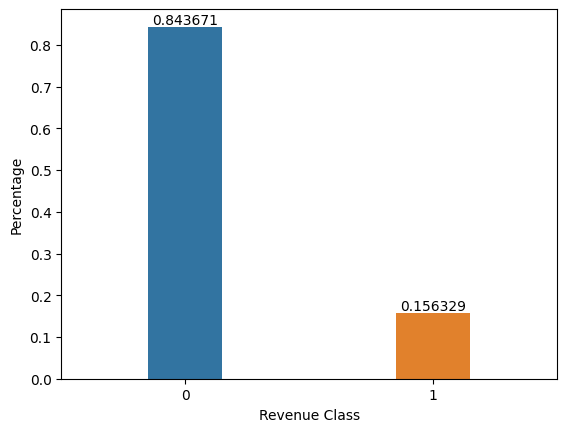

In [10]:
print("The percentage of each class in the dataset:\nClass TRUE: {0:.3f} %\nClass FALSE: {1:.3f} %\n"\
      .format(df['Revenue'].value_counts('True')[1], df['Revenue'].value_counts('True')[0]))

# check distribution of our classes
print("Plot displaying the class imbalance:\n")
ax=sb.barplot(data=df, x = df['Revenue'].unique() ,y = df['Revenue'].value_counts('True'), width=0.3)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Revenue Class', ylabel='Percentage')
plt.show()

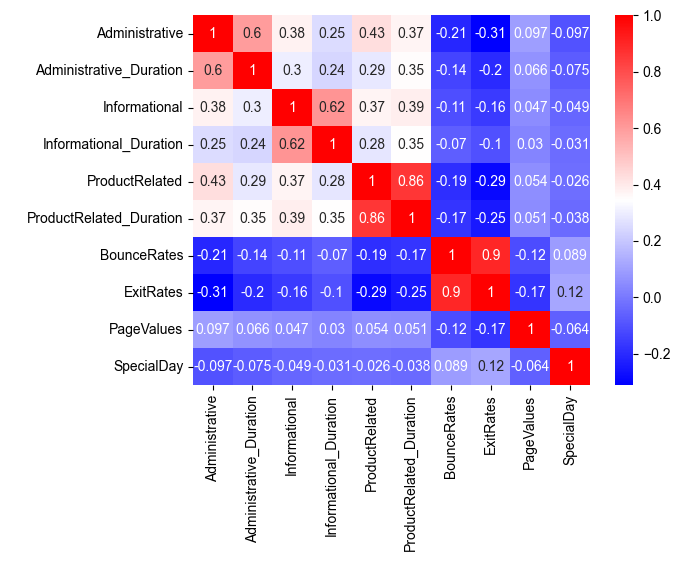

In [11]:
#correlation analysis of numerical features
corr = df_num.corr(numeric_only=True)
sb.heatmap(corr, cmap='bwr', annot=True, annot_kws={'fontsize':10}) #pearson's R - only used for numerical variables
sb.set (rc = {'figure.figsize':(15, 12)})
plt.show()

1. The distribution of the features can be seen to be skewed - solution can be normalized.
2. The features, bounce_rates and exit_rates are highly correlated (0.91)
3. Features productRelated and product related duration have high correlation (0.86)

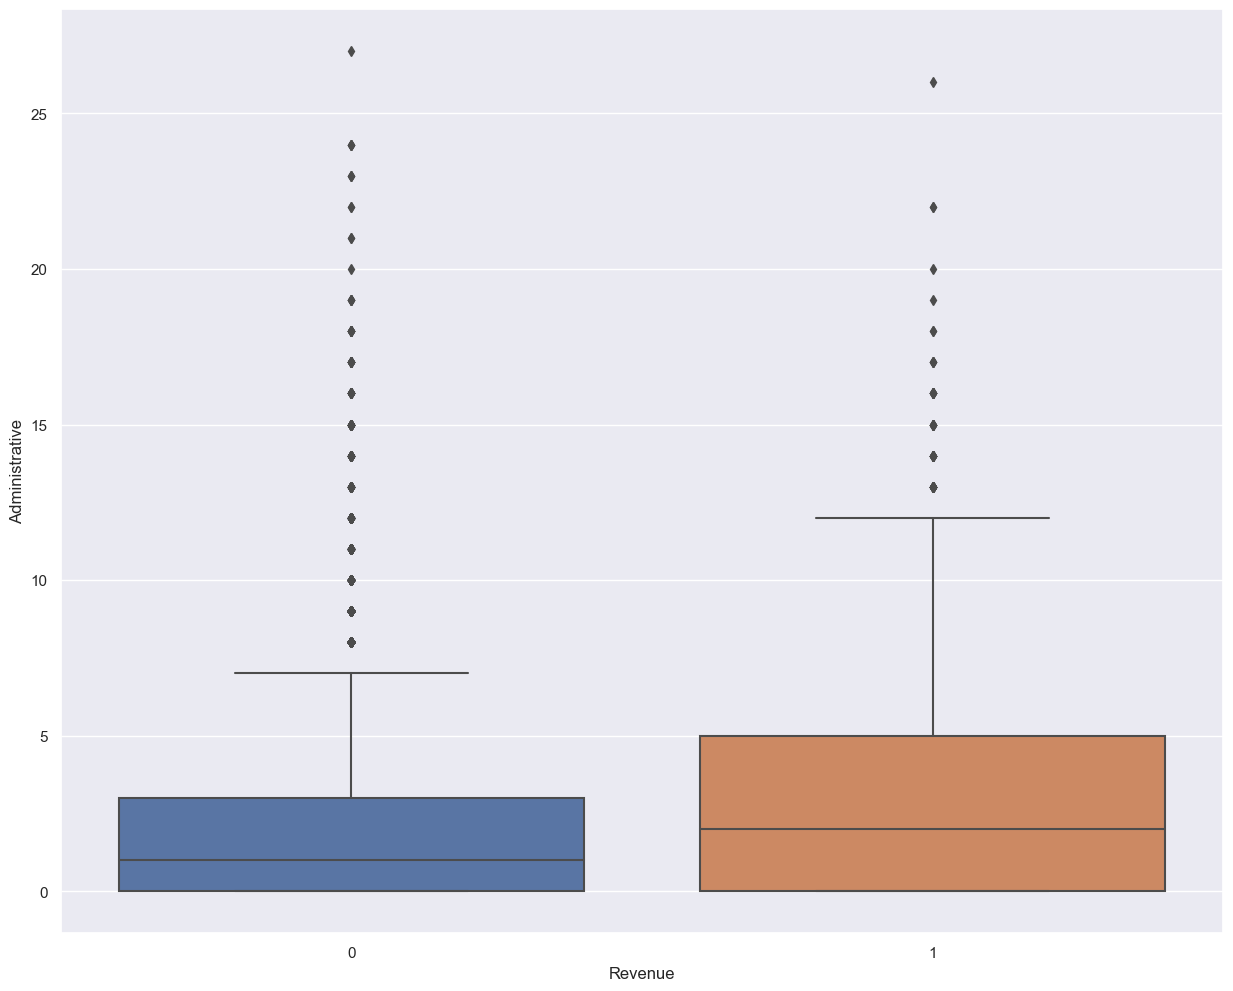

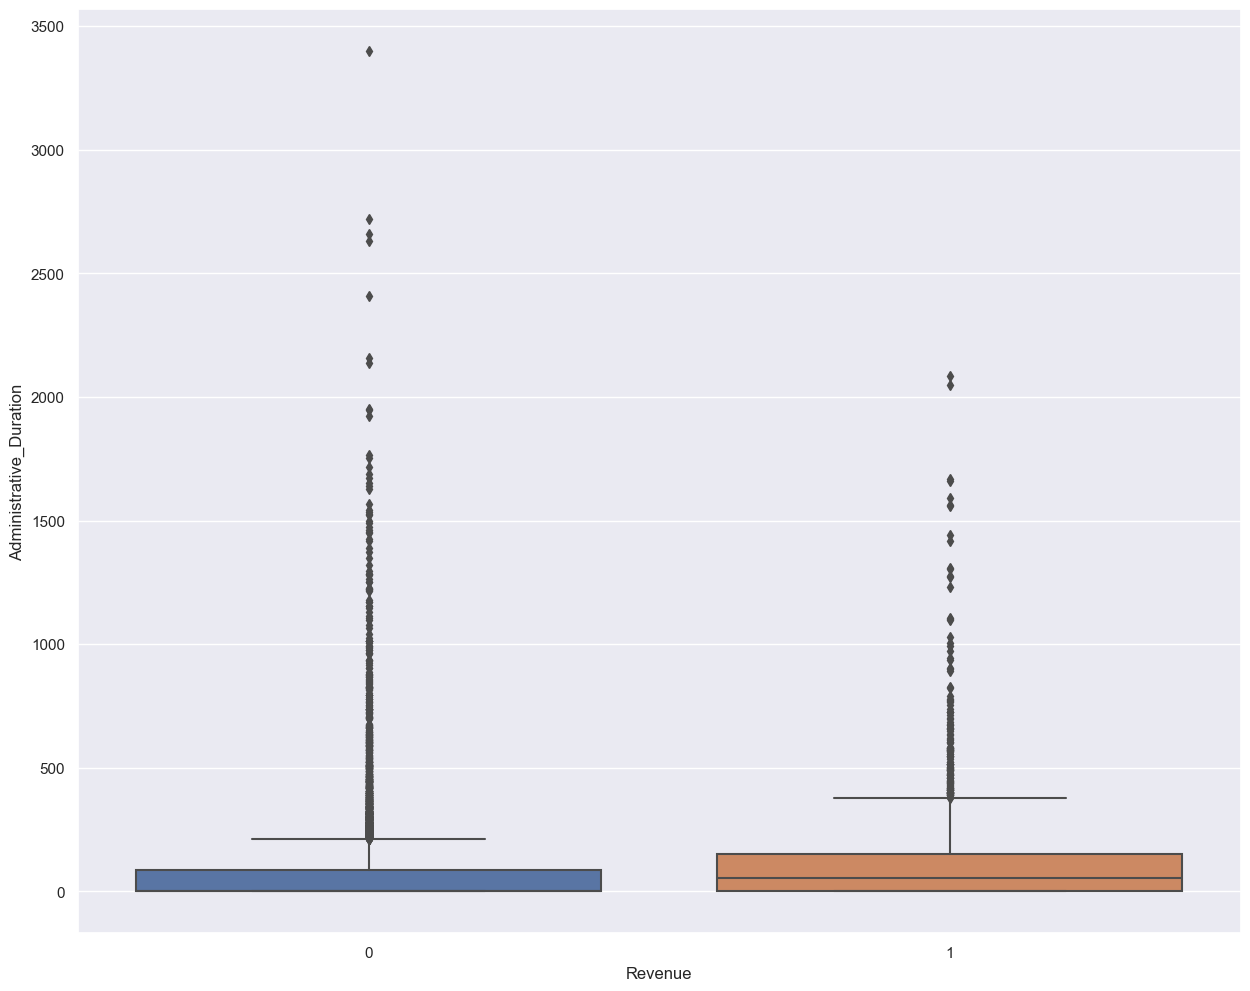

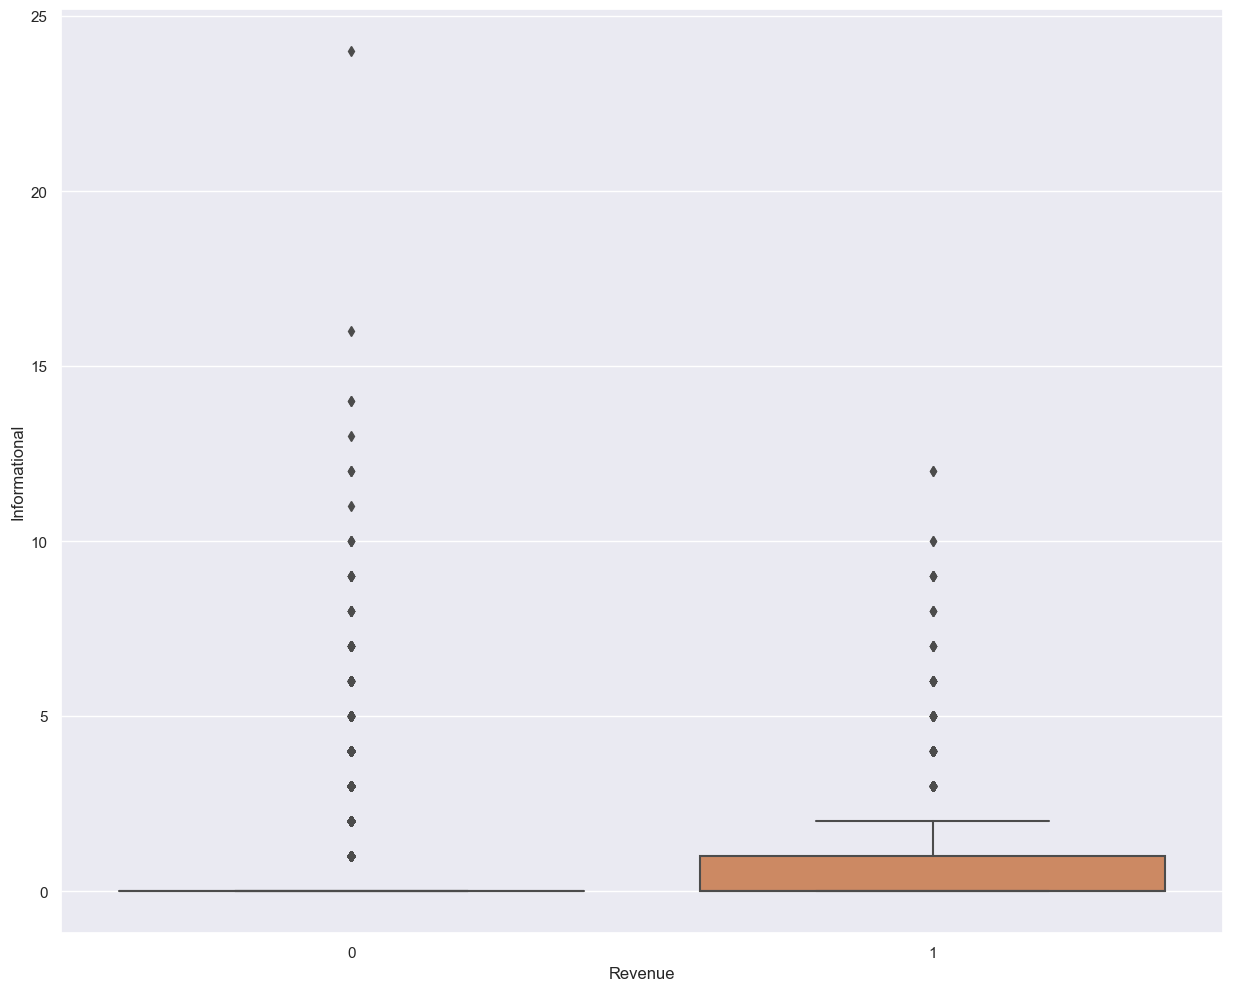

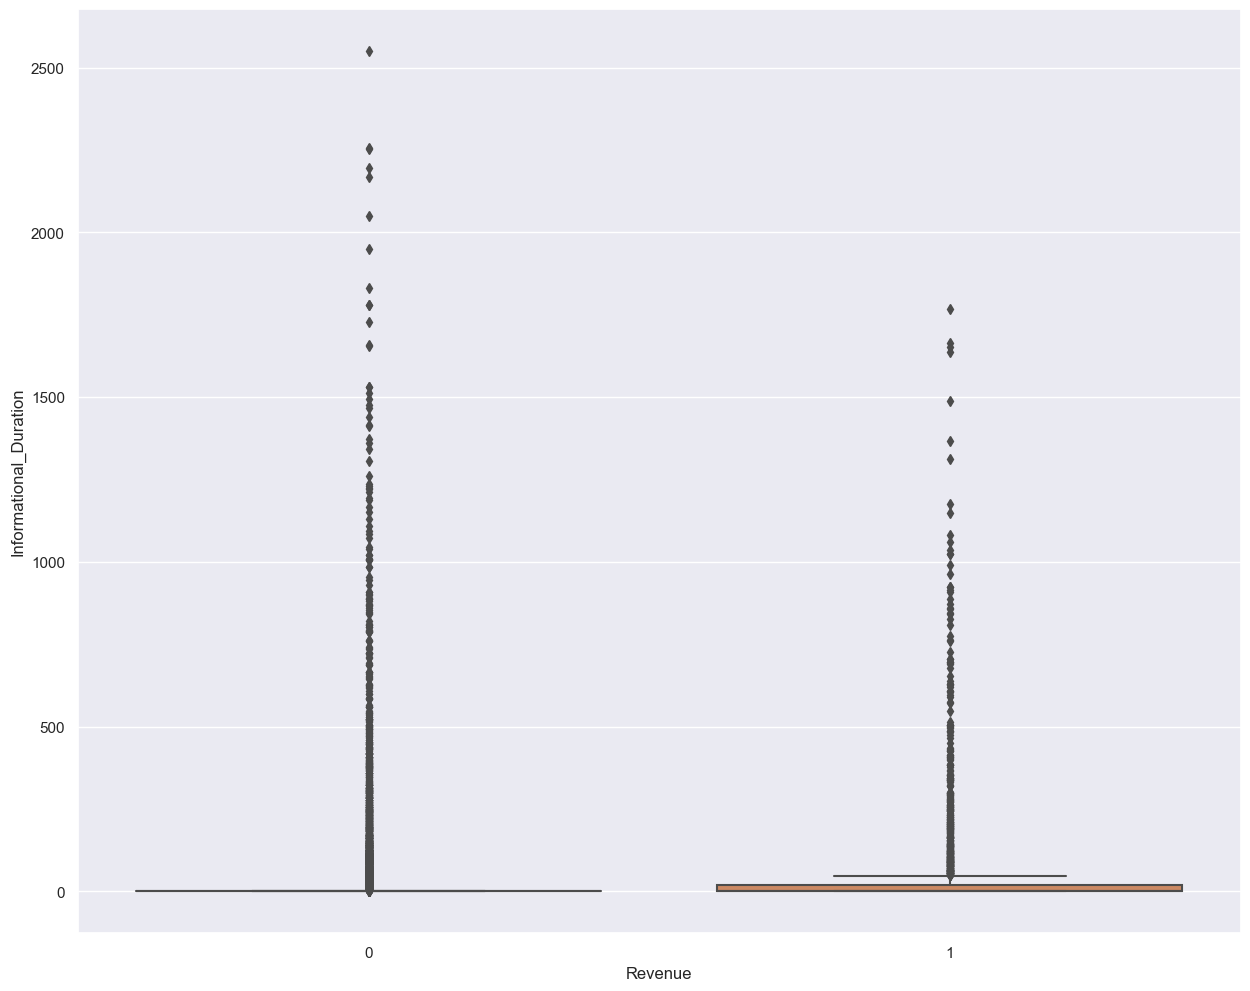

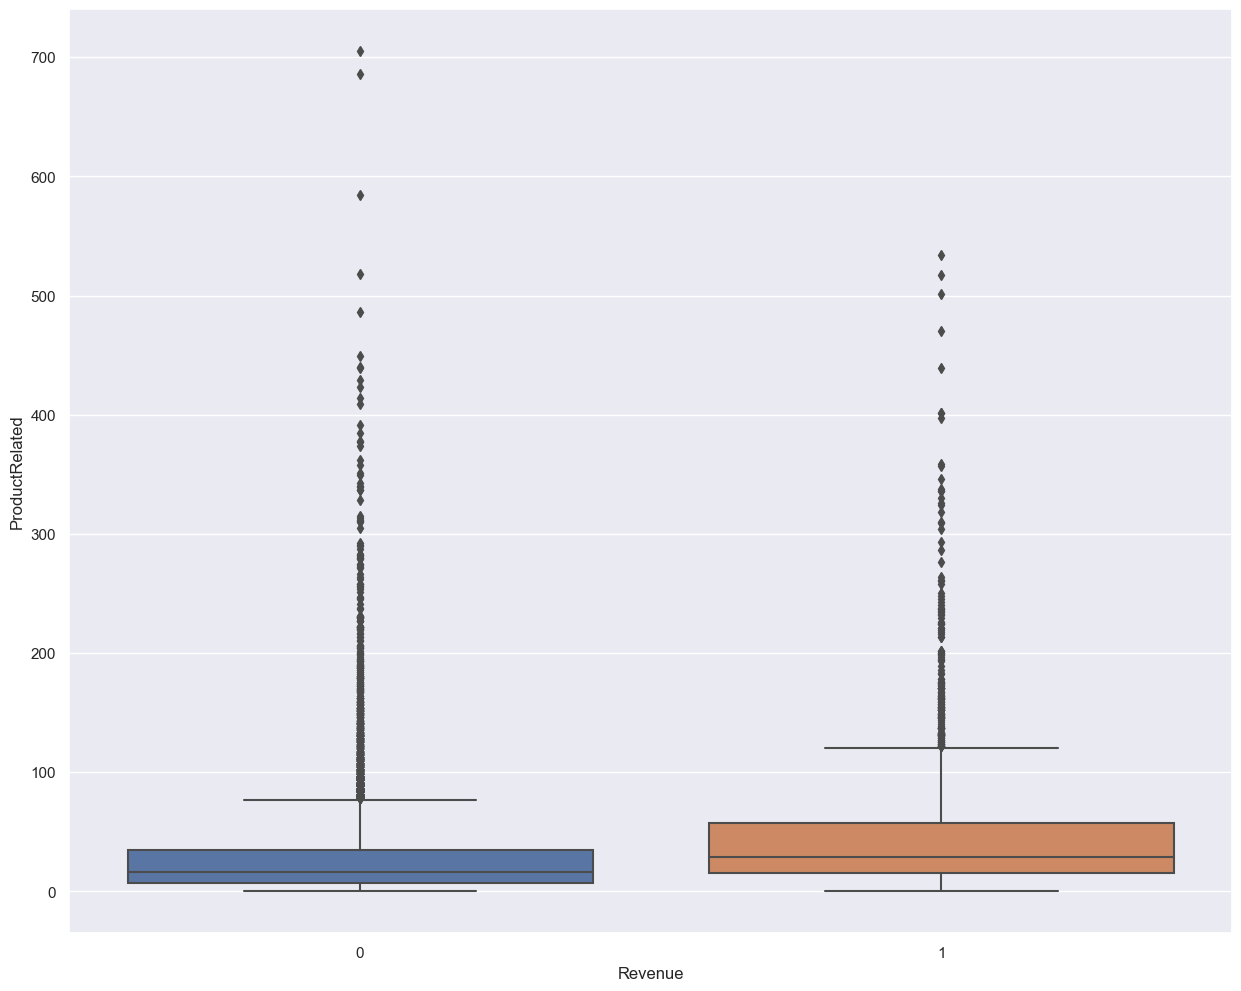

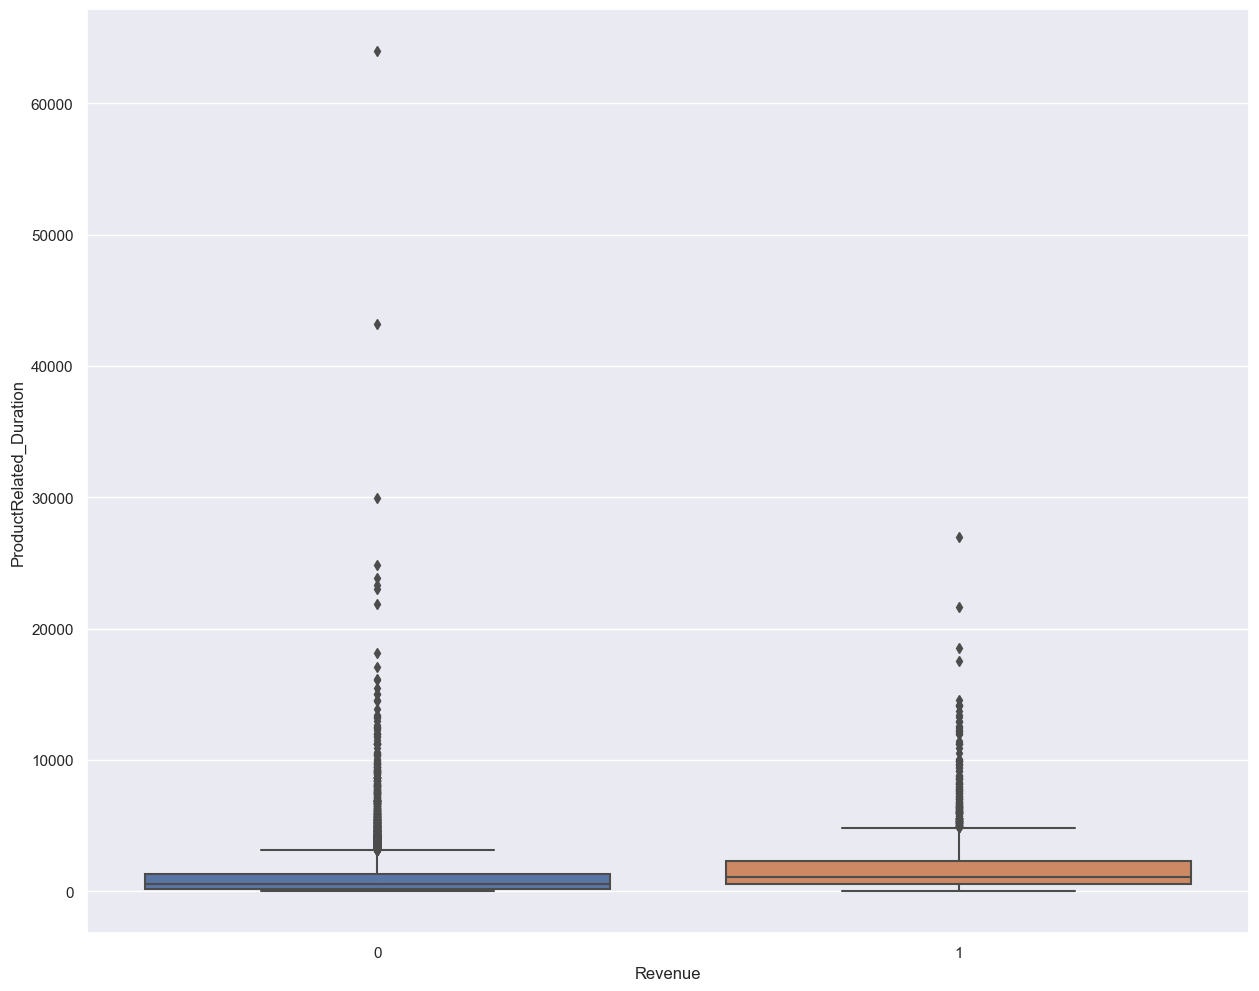

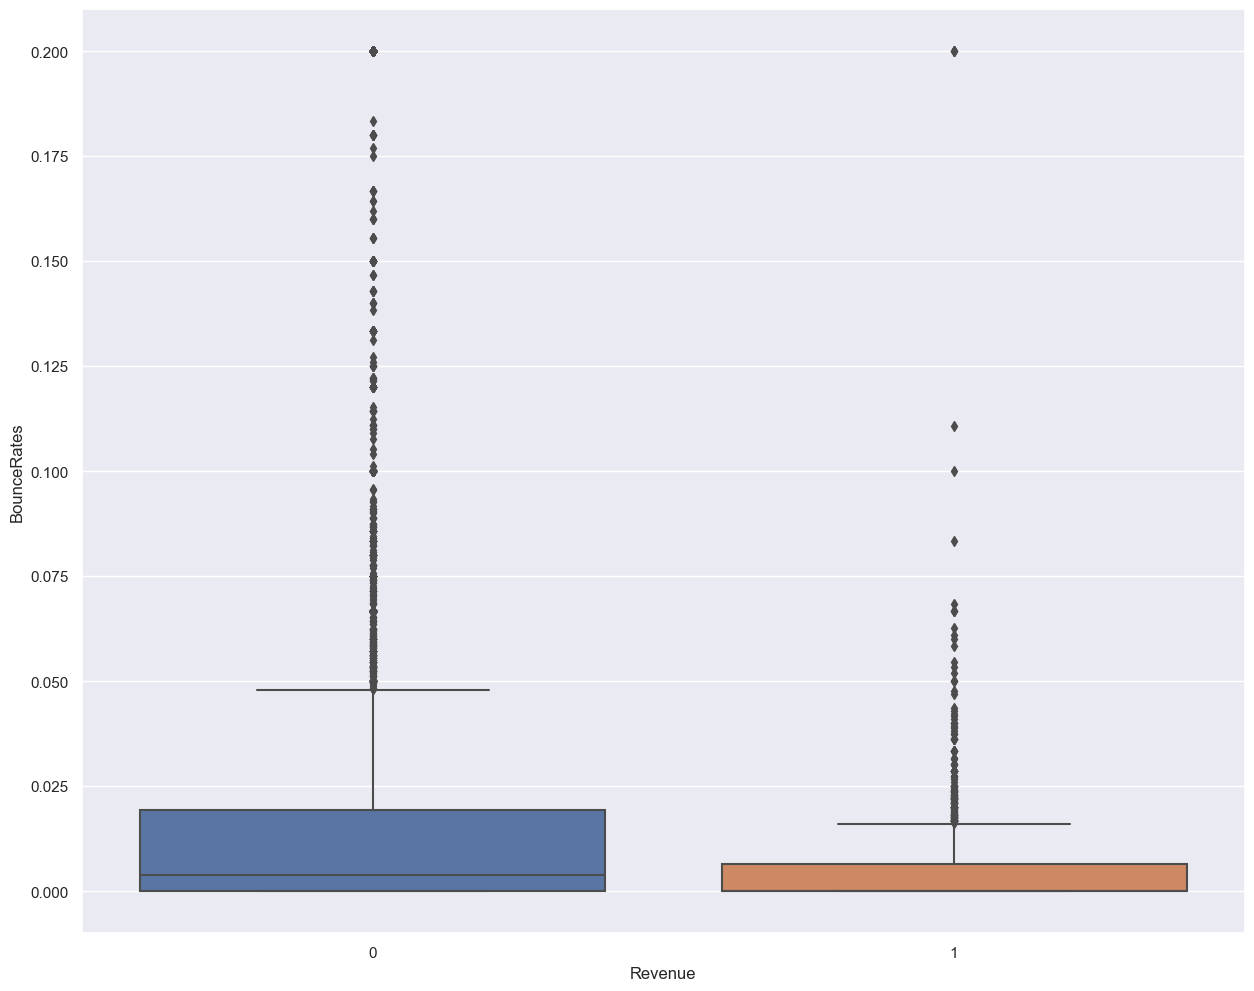

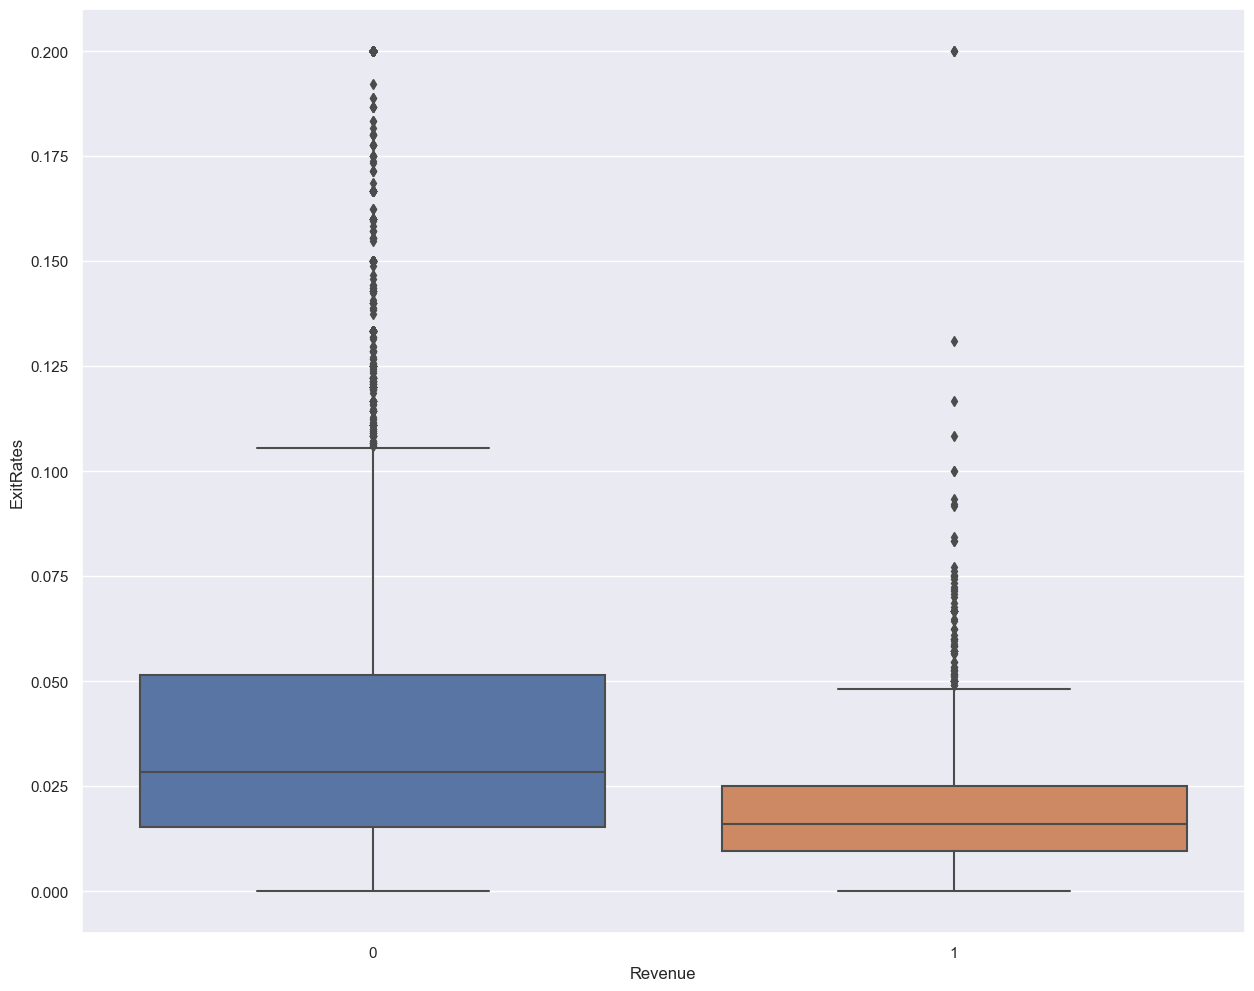

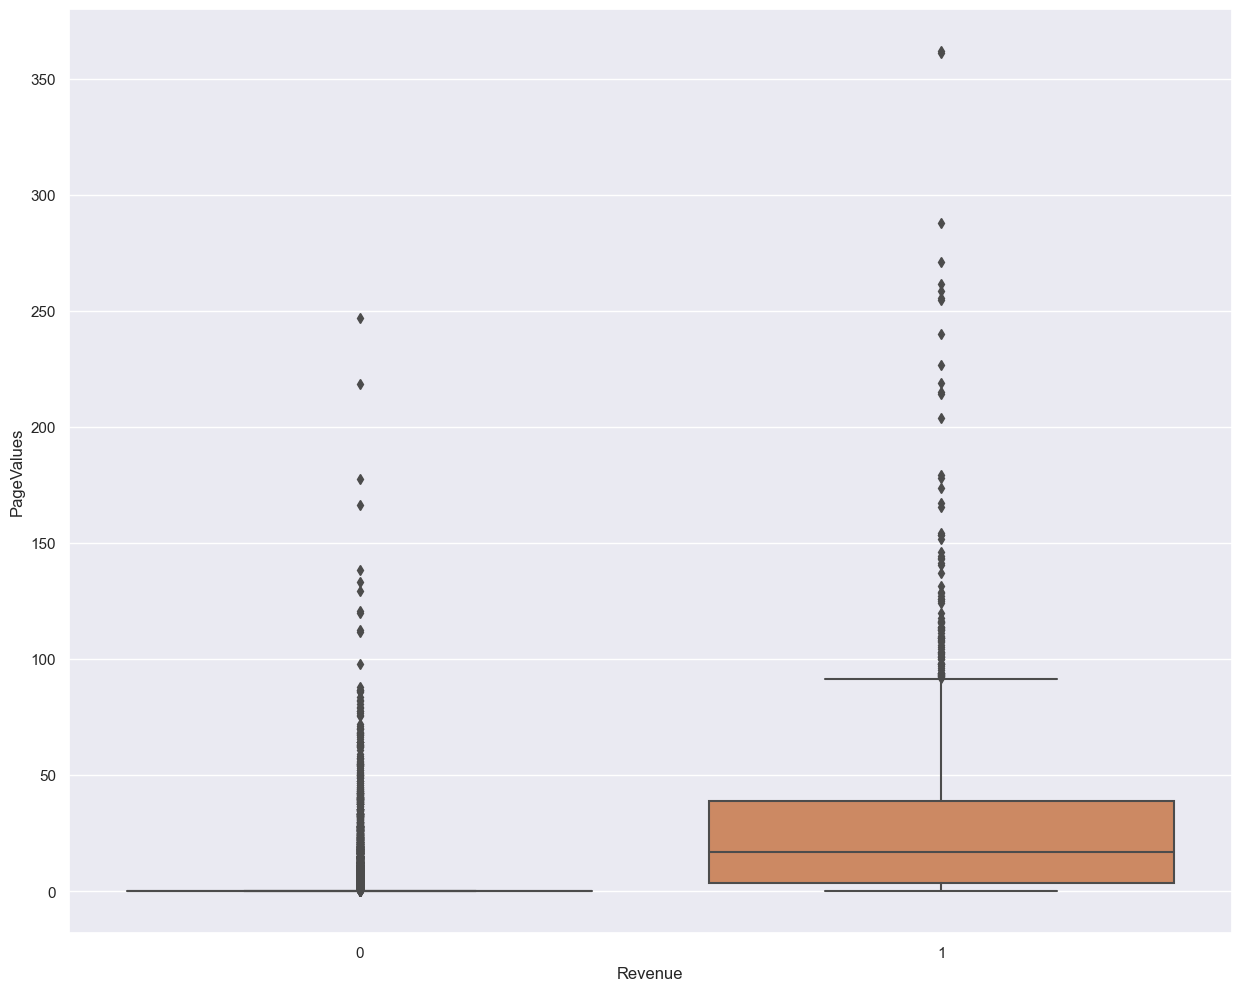

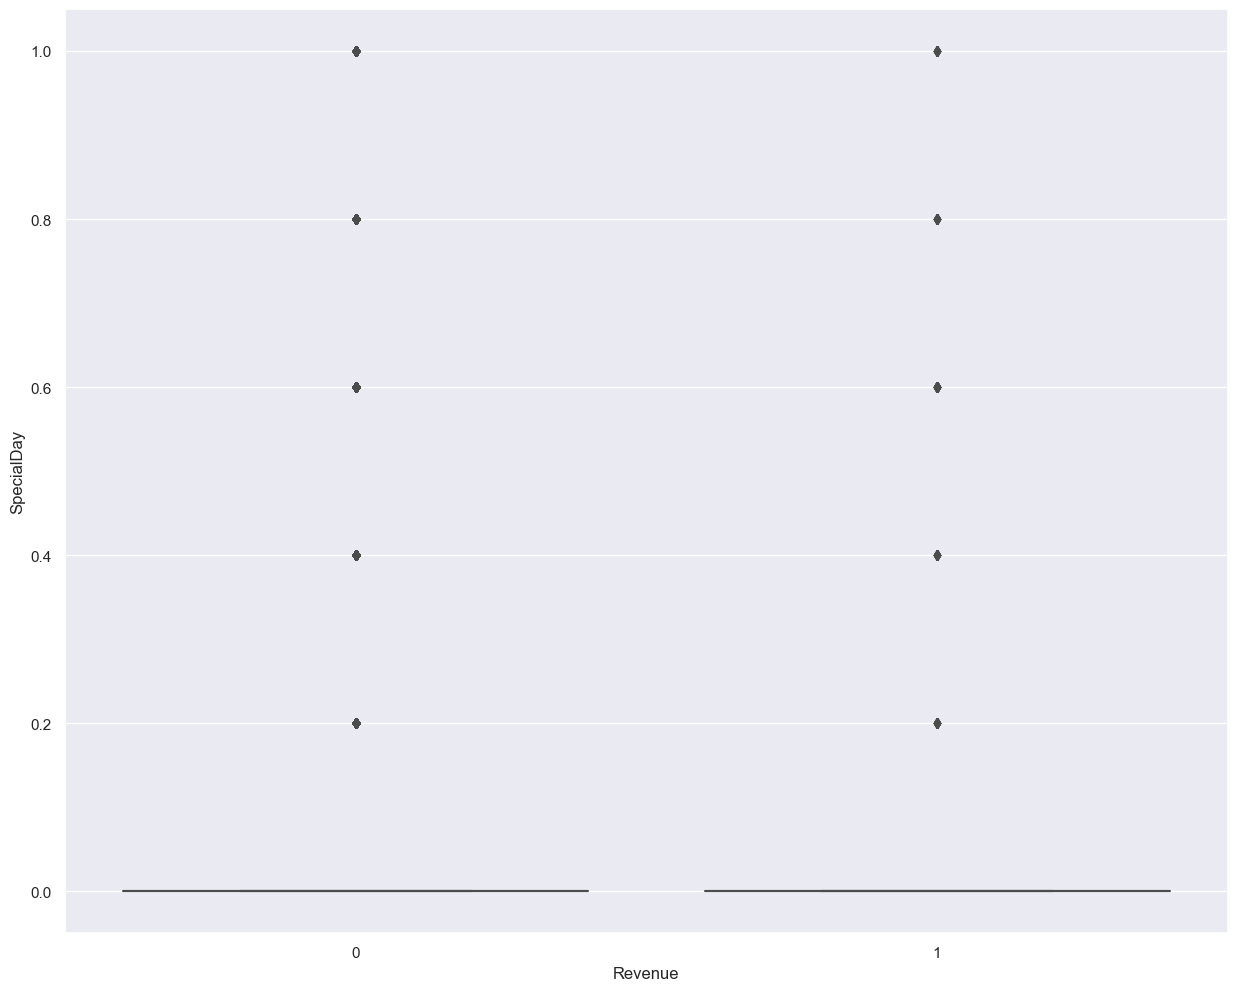

In [12]:
ax = sb.boxplot(x = 'Revenue', y = 'Administrative', data = df)
plt.show()
ax1 = sb.boxplot(x = 'Revenue', y = 'Administrative_Duration', data = df)
plt.show()
sb.boxplot(data=df, x='Revenue', y='Informational')
plt.show()
sb.boxplot(data=df, x='Revenue', y='Informational_Duration')
plt.show()
sb.boxplot(data=df, x='Revenue', y='ProductRelated')
plt.show()
sb.boxplot(data=df, x='Revenue', y='ProductRelated_Duration')
plt.show()
sb.boxplot(data=df, x='Revenue', y='BounceRates')
plt.show()
sb.boxplot(data=df, x='Revenue', y='ExitRates')
plt.show()
sb.boxplot(data=df, x='Revenue', y='PageValues')
plt.show()
sb.boxplot(data=df, x='Revenue', y='SpecialDay')
plt.show()

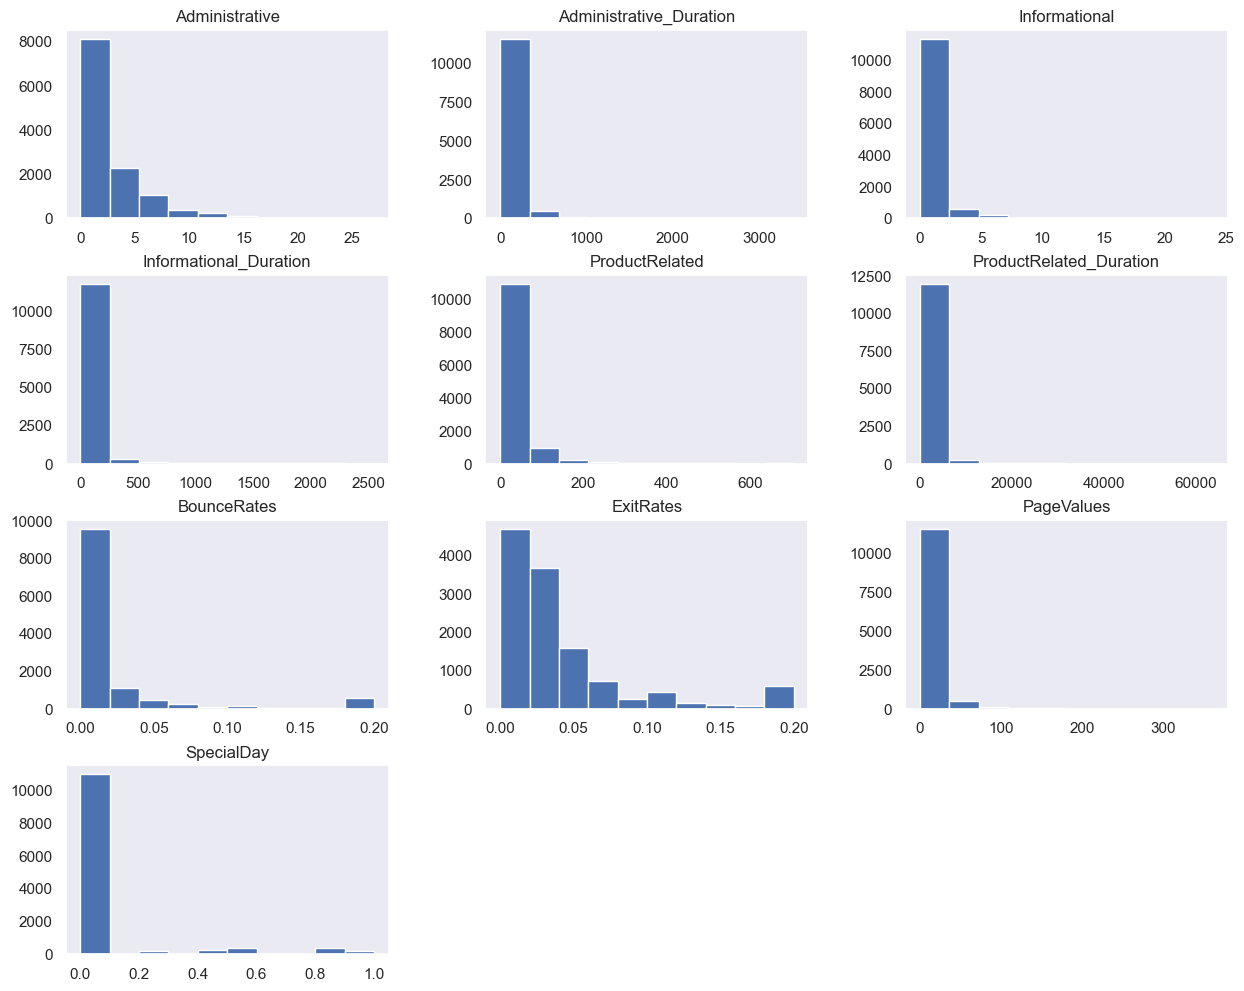

In [12]:
df_num.hist(bins=10, figsize=(15,12), grid=False)
plt.show()

## Feature Selection

In [13]:
# Implementing Feature selection techniques numerical data
df = df.drop(['ProductRelated','ExitRates',],axis=1) #dropping highly correlated columns
df.insert(len(df.columns)-1, 'TotalDuration', 0)
df['TotalDuration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df = df.drop(['Administrative_Duration','Informational_Duration', 'ProductRelated_Duration'],axis=1)
df.head()

,Administrative,Informational,BounceRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,...,Month__June,Month__Mar,Month__May,Month__Nov,Month__Oct,Month__Sep,Visitor__New_Visitor,Visitor__Other,TotalDuration,Visitor__Returning_Visitor
0,0,0,0.20,0.0,0.0,1,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
1,0,0,0.00,0.0,0.0,2,2,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.000000,1.0
2,0,0,0.20,0.0,0.0,4,1,9,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
3,0,0,0.05,0.0,0.0,3,2,2,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.666667,1.0
4,0,0,0.02,0.0,0.0,3,3,1,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,627.500000,1.0


(array([1.05265451e+00, 8.75709727e+00, 3.61670149e+00, 1.52516520e+00,
       7.18597857e+00, 1.20902693e+00, 1.14231948e+01, 2.68039283e+01,
       4.13158991e-02, 6.43603845e+00, 3.97691961e+01, 5.50160239e+01,
       2.19512233e+02, 1.17554986e+01, 4.31336184e+00, 1.10860477e+02,
       1.04255114e+00, 1.87645984e+01]), array([3.04896519e-01, 3.08399512e-03, 5.72021805e-02, 2.16839515e-01,
       7.34754692e-03, 2.71524921e-01, 7.25328658e-04, 2.25179130e-07,
       8.38929374e-01, 1.11827762e-02, 2.85817567e-10, 1.19551173e-13,
       1.15552312e-49, 6.06637595e-04, 3.78141629e-02, 6.34851424e-26,
       3.07228885e-01, 1.47886951e-05]))


<AxesSubplot: >

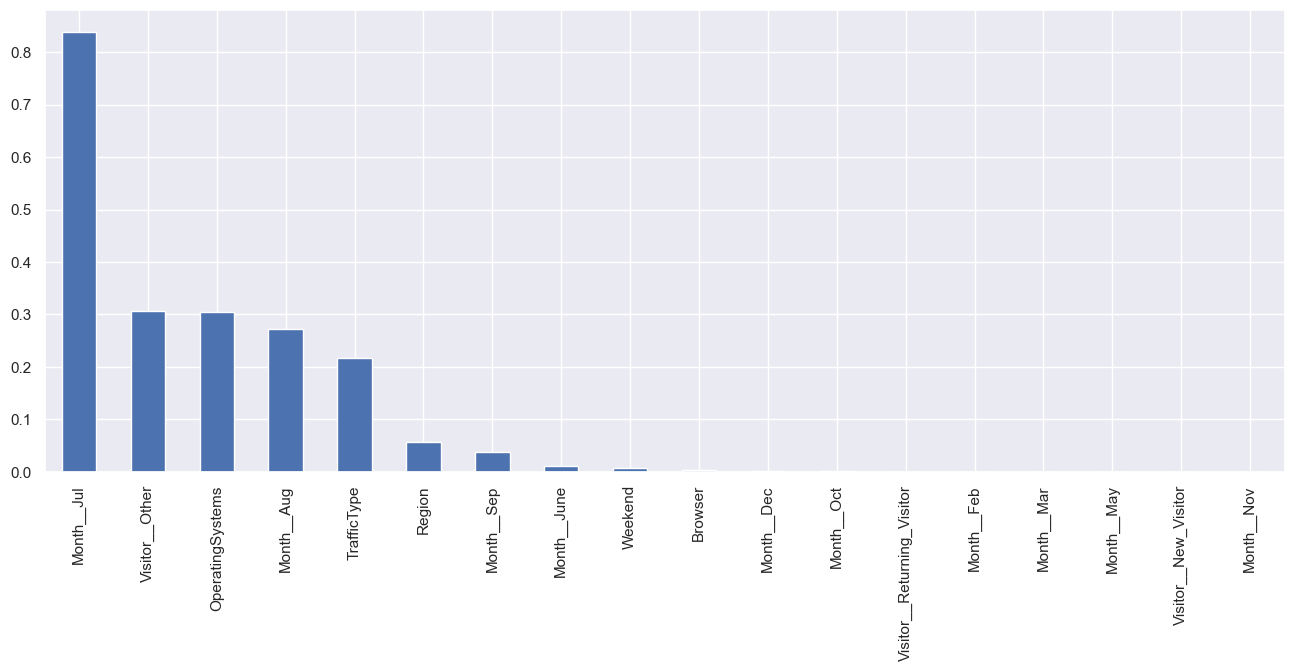

In [14]:
#Applying Chi-squared on the categorical data
df_cat_y = df_cat["Revenue"]
df_cat_X = df_cat.drop(["Revenue"], axis =1)

chi_scores = chi2(df_cat_X,df_cat_y)
print(chi_scores)
p_values = pd.Series(chi_scores[1], index = df_cat_X.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.figure(figsize=(16,6))
p_values.plot.bar()

In [15]:
p_values

Month__Jul                    8.389294e-01
Visitor__Other                3.072289e-01
OperatingSystems              3.048965e-01
Month__Aug                    2.715249e-01
TrafficType                   2.168395e-01
Region                        5.720218e-02
Month__Sep                    3.781416e-02
Month__June                   1.118278e-02
Weekend                       7.347547e-03
Browser                       3.083995e-03
Month__Dec                    7.253287e-04
Month__Oct                    6.066376e-04
Visitor__Returning_Visitor    1.478870e-05
Month__Feb                    2.251791e-07
Month__Mar                    2.858176e-10
Month__May                    1.195512e-13
Visitor__New_Visitor          6.348514e-26
Month__Nov                    1.155523e-49
dtype: float64

In [16]:
df = df.drop(['OperatingSystems','Region', 'TrafficType',
       'Month__Aug', 'Month__Jul', 'Visitor__Other'], axis = 1)

In [17]:
df.columns

Index(['Administrative', 'Informational', 'BounceRates', 'PageValues',
       'SpecialDay', 'Browser', 'Weekend', 'Revenue', 'Month__Dec',
       'Month__Feb', 'Month__June', 'Month__Mar', 'Month__May', 'Month__Nov',
       'Month__Oct', 'Month__Sep', 'Visitor__New_Visitor', 'TotalDuration',
       'Visitor__Returning_Visitor'],
      dtype='object')

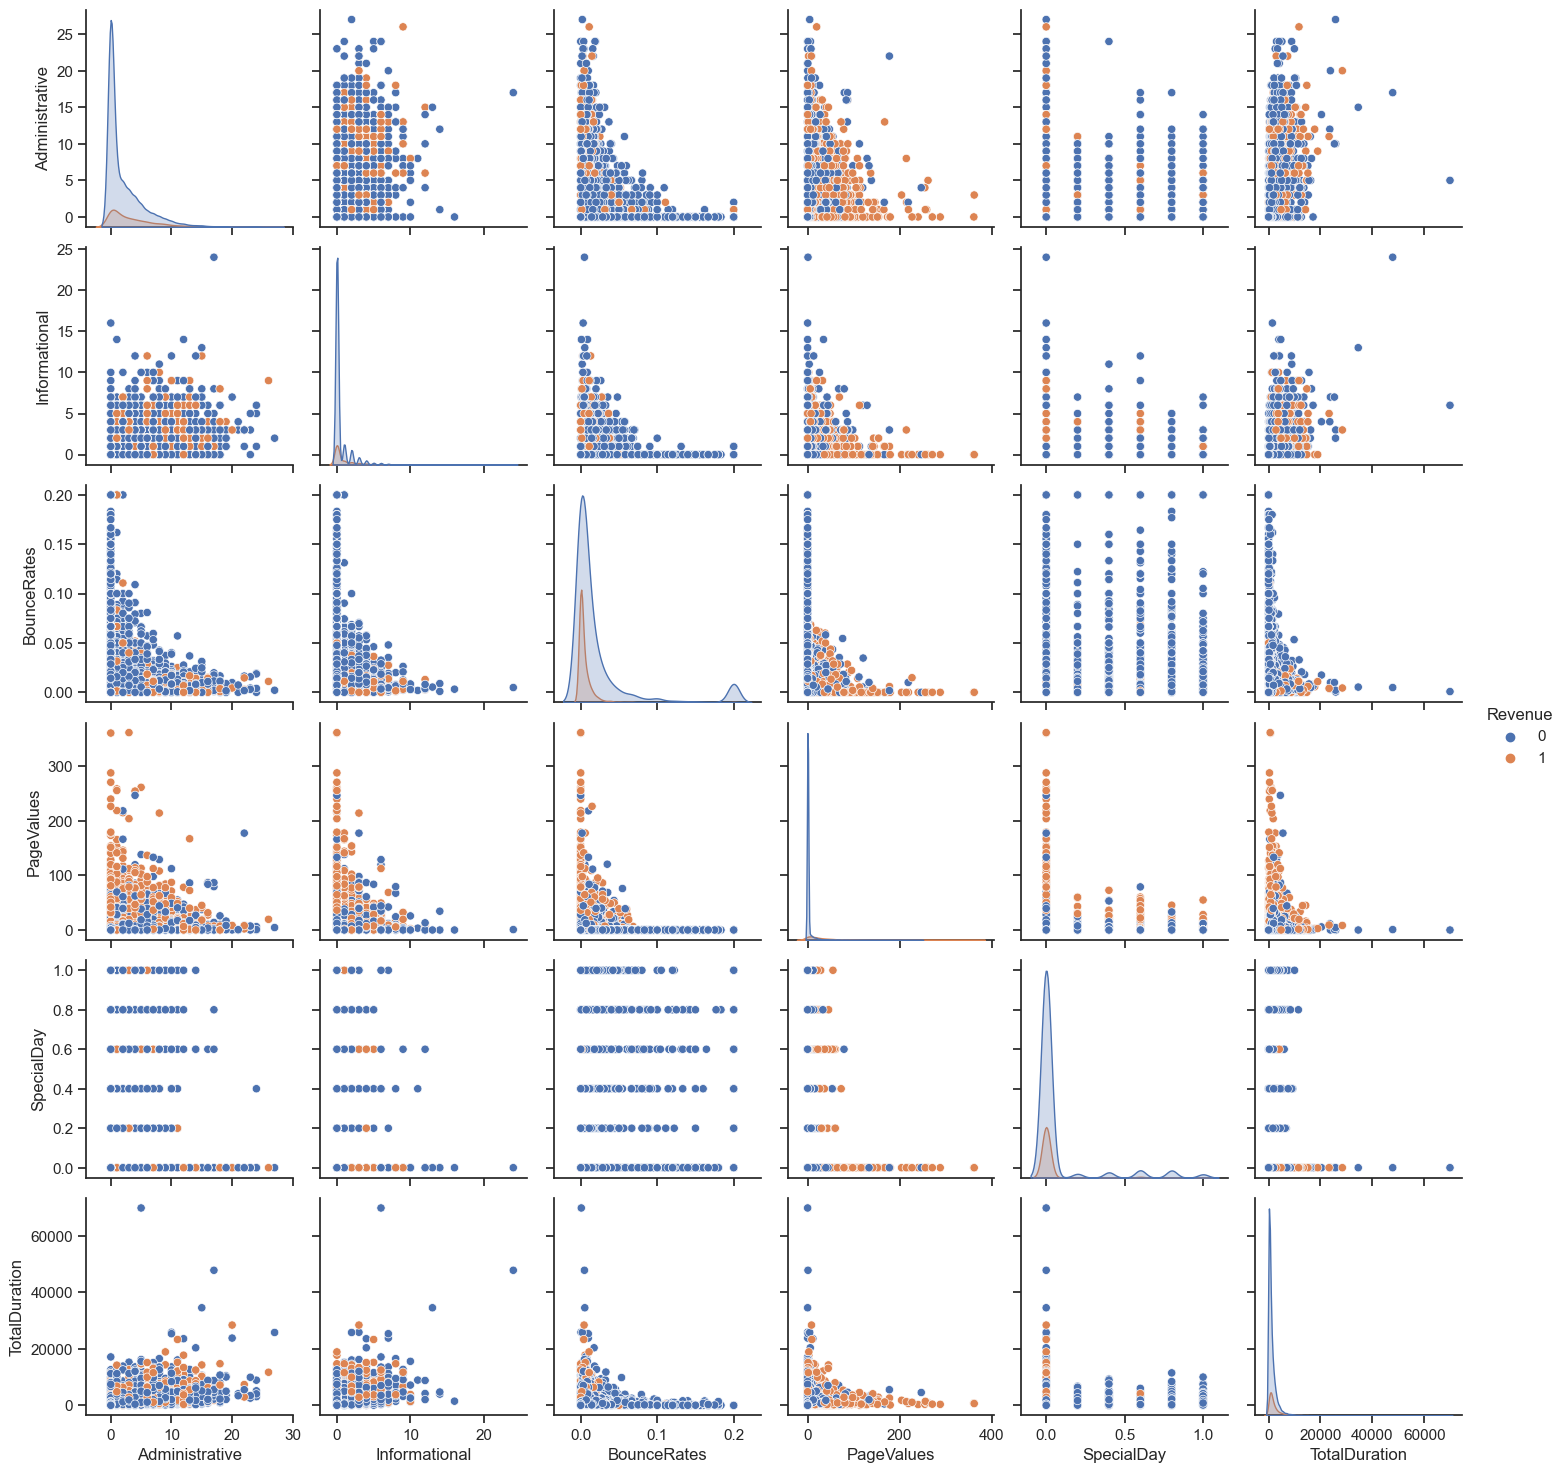

In [20]:
df_num = df[['Administrative', 'Informational', 'BounceRates', 'PageValues', 'SpecialDay', 'TotalDuration', 'Revenue']]
sb.set_theme(style="ticks")
sb.pairplot(df_num, diag_kind='kde', hue="Revenue")

## Data Splitting to Train, and Test

In [18]:
X = df.loc[:, ['Administrative', 'Informational', 'BounceRates', 'PageValues',
       'SpecialDay', 'Browser', 'Weekend', 'Month__Dec',
       'Month__Feb', 'Month__June', 'Month__Mar', 'Month__May', 'Month__Nov',
       'Month__Oct', 'Month__Sep', 'Visitor__New_Visitor', 'TotalDuration',
       'Visitor__Returning_Visitor']] #selecting all variables except revenue  - target variable

y = df["Revenue"]

In [19]:
#splitting train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=24, stratify=y)
#checking the shape of the split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#index reset
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(drop=True, inplace=True)

(9764, 18) (9764,) (2441, 18) (2441,)


In [20]:
"""Training Model - working only with training data now"""
#normalizing numerical features
num_cols = ['Administrative', 'Informational', 'BounceRates', 'PageValues',
       'SpecialDay', 'TotalDuration']

# mean and std for test data
mean = X_train.loc[:, num_cols].mean()
std = X_train.loc[:, num_cols].std()
X_train.loc[:, num_cols] = (X_train.loc[:, num_cols] - X_train.loc[:, num_cols].mean())/X_train.loc[:, num_cols].std()    

train_column_names = X_train.columns.values

In [24]:
X_train, y_train

,Administrative,Informational,BounceRates,PageValues,SpecialDay,Browser,Weekend,Month__Dec,Month__Feb,Month__June,Month__Mar,Month__May,Month__Nov,Month__Oct,Month__Sep,Visitor__New_Visitor,TotalDuration,Visitor__Returning_Visitor
0,0.192252,-0.395982,-0.121564,-0.314482,-0.309627,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.079613,1.0
1,-0.705332,-0.395982,1.781085,-0.314482,-0.309627,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.636438,1.0
2,-0.705332,-0.395982,-0.449607,-0.314482,-0.309627,2,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.642972,1.0
3,-0.406137,-0.395982,-0.449607,-0.314482,-0.309627,7,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.555718,0.0
4,-0.705332,-0.395982,0.665739,-0.314482,0.693758,2,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.258971,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,-0.705332,-0.395982,4.011777,-0.314482,2.700528,2,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.668606,1.0
9760,-0.705332,-0.395982,1.409303,-0.314482,-0.309627,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.610805,1.0
9761,-0.106943,-0.395982,-0.244748,0.516125,-0.309627,2,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.693574,1.0
9762,4.380977,2.664064,-0.405580,4.177439,-0.309627,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.659031,1.0


In [21]:
#standardizing the test set
X_test.loc[:, num_cols] = (X_test.loc[:, num_cols] - mean)/std

In [22]:
X_test

,Administrative,Informational,BounceRates,PageValues,SpecialDay,Browser,Weekend,Month__Dec,Month__Feb,Month__June,Month__Mar,Month__May,Month__Nov,Month__Oct,Month__Sep,Visitor__New_Visitor,TotalDuration,Visitor__Returning_Visitor
0,1.389030,1.134041,-0.349351,0.021642,-0.309627,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.509237,1.0
1,-0.705332,-0.395982,-0.449607,-0.314482,-0.309627,2,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.449464,1.0
2,-0.705332,-0.395982,-0.255634,-0.314482,-0.309627,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.072105,1.0
3,-0.106943,4.194087,-0.449607,-0.314482,-0.309627,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.760166,1.0
4,-0.406137,4.194087,0.277855,-0.314482,-0.309627,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112853,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,1.089836,0.369030,-0.230930,-0.314482,-0.309627,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111548,1.0
2437,-0.705332,-0.395982,1.437902,-0.314482,-0.309627,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.506109,1.0
2438,-0.705332,-0.395982,2.227224,-0.314482,-0.309627,10,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.563056,1.0
2439,-0.406137,-0.395982,-0.449607,-0.314482,-0.309627,2,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.658051,1.0


In [23]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
2436    0
2437    0
2438    0
2439    0
2440    0
Name: Revenue, Length: 2441, dtype: int64

## Max Margin SVM Soft Margin

In [56]:
#for SVM, due to complexity of the algorithm we sample the dataset and try to run it.
## Initial run with 500 records and calculate time
X_svm = X_train.iloc[0: 500, 0:].to_numpy()
y_svm = y_train[0: 500]

In [57]:
@dataclass 
class SoftMarginSVM():
    C: float = 100
    kernel: str = 'Linear'
    
    def dualSVM(self, gramXy, alphas):
        return alphas.sum() - 0.5 * alphas.dot(alphas.dot(gramXy))
    
    def jacobian_dualSVM(self, gramXy, alphas):
        return np.ones(len(alphas)) - alphas.dot(gramXy)
    
    def fit(self, X, y):
        N, features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        if self.kernel == 'Linear':
            Xy = (X * y_[:, np.newaxis]) #polynomial degree 2
            gramXy = Xy.dot(Xy.T)
        
        alphas = np.ones(N)
        
        bounds = Bounds(np.zeros(N), np.full(N, self.C))
        constraints = ({'type':"eq", 'fun':lambda a: -np.dot(a, y_),
                        'jac': lambda a: -y_})
        
        slsqp = minimize(fun = lambda a: -self.dualSVM(gramXy, a),
                         x0 = alphas,
                         jac = lambda a: -self.jacobian_dualSVM(gramXy, a),
                         bounds=bounds,
                         constraints=constraints,
                         method = 'SLSQP')
        
        self.alphas = slsqp.x
        self.w = np.sum((self.alphas[:, np.newaxis] * Xy), axis =0)
        
        epsilon = 1e-6
        self.support_vectors = X[self.alphas > epsilon]
        sign_dist = np.matmul(self.support_vectors, self.w)
        
        min_dist = np.argmin(sign_dist)
        support_labels = y_[self.alphas > epsilon]
        
        b = []
        for i in range(len(support_labels)):
            b_i = support_labels[i] - np.matmul(self.support_vectors[i].T, self.w)
            b.append(b_i)
        self.intercept = sum(b)/len(b)
        # support_labels[min_dist] - sign_dist[min_dist]
    
    def evaluate(self, y, y_hat): #y = original labels, y_hat = predicted labels
        y = (y==1)
        y_hat = (y_hat==1)
        precision = (y & y_hat).sum() / y_hat.sum() #percentage of times the function could predict it correctly for class 1
        recall = (y & y_hat).sum() / y.sum() #the precentage of what we could find of the positive class
        f1_score = 2 * (precision * recall) / (precision + recall) #on an average our accuracy in prediction
        return recall, precision, f1_score
    
    def predict(self, X):
        y_hat = np.sign(X.dot(self.w) + self.intercept)
        y_hat = np.where(y_hat <=0, 0, 1)
        return y_hat

In [58]:
#training on 500 samples
cpu_starttime = time.process_time()
start_time = time.time()

svm_model = SoftMarginSVM()
svm_model.fit(X_svm, y_svm)

cpu_endtime = time.process_time()
end_time = time.time()

In [59]:
y_hat = svm_model.predict(X_svm)
print(confusion_matrix(y_svm, y_hat))
print("CPU processing time when the SVM model was run with : ", (cpu_endtime - cpu_starttime))
print("time taken to train the SVM model: ", (end_time - start_time))

[[409  16]
 [ 32  43]]
CPU processing time when the SVM model was run with :  54.453125
time taken to train the SVM model:  56.687856674194336


In [75]:
#training on 1000 samples
cpu_time = []
total_time = []
samples = []

for i in [100, 300, 500, 700, 900, 1000]:
    samples.append(i)
    
    X_svm = X_train.iloc[0: i, 0:].to_numpy()
    y_svm = y_train[0: i]

    cpu_starttime = time.process_time()
    start_time = time.time()

    svm_model = SoftMarginSVM()
    svm_model.fit(X_svm, y_svm)

    cpu_endtime = time.process_time()
    end_time = time.time()

    y_hat = svm_model.predict(X_svm)
    print(confusion_matrix(y_svm, y_hat))
    print(f"CPU processing time when the SVM model was run with {i} samples: {(cpu_endtime - cpu_starttime)}")
    print("time taken to train the SVM model: ", (end_time - start_time))
    
    cpu_time.append((cpu_endtime - cpu_starttime))
    total_time.append((end_time - start_time))
    
parameters = pd.DataFrame(list(zip(samples, cpu_time, total_time)),
            columns =['Trainig Samples', 'CPU Processing Time','Total training time'])

[[81  2]
 [ 2 15]]
CPU processing time when the SVM model was run with 100 samples: 0.40625
time taken to train the SVM model:  0.42189550399780273
[[237  11]
 [ 23  29]]
CPU processing time when the SVM model was run with 300 samples: 11.84375
time taken to train the SVM model:  12.001764297485352
[[409  16]
 [ 32  43]]
CPU processing time when the SVM model was run with 500 samples: 54.78125
time taken to train the SVM model:  55.31515431404114
[[581  21]
 [ 42  56]]
CPU processing time when the SVM model was run with 700 samples: 163.59375
time taken to train the SVM model:  167.74076533317566
[[735  28]
 [ 61  76]]
CPU processing time when the SVM model was run with 900 samples: 342.96875
time taken to train the SVM model:  346.91190123558044
[[817  29]
 [ 75  79]]
CPU processing time when the SVM model was run with 1000 samples: 490.359375
time taken to train the SVM model:  507.3505017757416


Text(0, 0.5, 'CPU processing time in seconds')

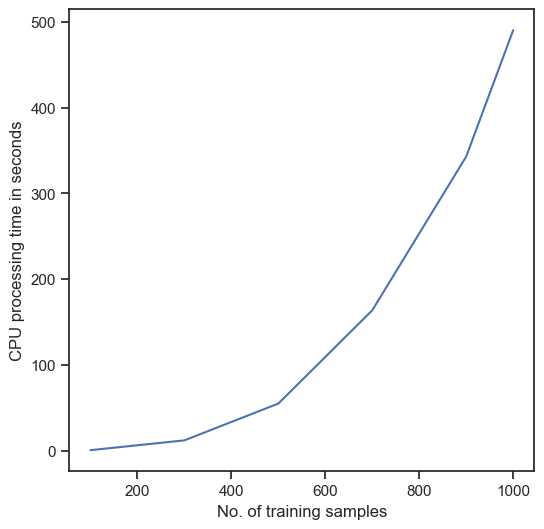

In [78]:

plt.plot(parameters["Trainig Samples"], parameters['CPU Processing Time'])
plt.xlabel("No. of training samples")
plt.ylabel("CPU processing time in seconds")

In [60]:
svm_model.w, svm_model.intercept

(array([ 9.34427386e-02,  3.66726149e-02, -9.40431261e-01,  1.20986620e+00,
         3.12843416e-01, -1.71813741e-01,  7.11124130e-02,  5.26500610e-01,
        -1.83749778e-01, -4.73767075e-01,  2.36456321e-01, -5.12037993e-01,
         6.50203188e-01, -5.20996366e-08,  6.42710126e-01,  7.38902821e-02,
         3.49355787e-02, -7.38924409e-02]),
 -0.7482318107514679)

In [61]:
svm_model.evaluate(y_svm, y_hat)

(0.5733333333333334, 0.7288135593220338, 0.6417910447761194)

## Neural Networks

Model_1 development:
1. Starting with 1 hidden layer, input and output layers
2. Using SGD as the optimizer
3. No need of separate validation data, we have it
4. no. of nodes is 8 in the hidden layer
5. Epochs = 10

In [73]:
#initializing model
model_1 = tf.keras.Sequential()

In [74]:
#creating the NN Model

model_1.add(Dense(8, activation = 'relu', input_shape = (18,), name='Hidden_layer_1'))
model_1.add(Dense(1, activation = 'sigmoid', name = 'Output_layer'))

model_1.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy', 'Precision', 'Recall'])

print(model_1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_1 (Dense)      (None, 8)                 152       
                                                                 
 Output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
#initializing model
model_2 = tf.keras.Sequential()

#creating the NN Model
model_2.add(Dense(8, activation = 'relu', input_shape = (18,), name='Hidden_layer_1'))

model_2.add(Dense(8, activation = 'relu', name='Hidden_layer_2'))

model_2.add(Dense(1, activation = 'sigmoid', name = 'Output_layer'))

model_2.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy', 'Precision', 'Recall'])

print(model_2.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer_1 (Dense)      (None, 8)                 152       
                                                                 
 Hidden_layer_2 (Dense)      (None, 8)                 72        
                                                                 
 Output_layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
history = model_1.fit(X_train, y_train, epochs=10)

Epoch 1/10
306/306 [==============================] - 1s 2ms/step - loss: 0.4930 - accuracy: 0.7950 - precision: 0.3200 - recall: 0.2772
Epoch 2/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3691 - accuracy: 0.8667 - precision: 0.7581 - recall: 0.2156
Epoch 3/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3338 - accuracy: 0.8740 - precision: 0.7467 - recall: 0.2936
Epoch 4/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3164 - accuracy: 0.8759 - precision: 0.7295 - recall: 0.3270
Epoch 5/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3078 - accuracy: 0.8771 - precision: 0.7251 - recall: 0.3440
Epoch 6/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3034 - accuracy: 0.8789 - precision: 0.7299 - recall: 0.3578
Epoch 7/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3004 - accuracy: 0.8796 - precision: 0.7285 - recall: 0.3657
Epoch 8/10
306/306 [=====================

In [76]:
# Checking for different cutoff values
cutoff=[0.1, 0.2, 0.5, 0.8, 0.95]

recall=[]
accuracy=[]

for i in cutoff:
  y_hat = (model_1.predict(X_train) > i).astype(int)
  y_hat = np.squeeze(y_hat,1)
  recall.append((y_hat & y_train).sum() / y_train.sum())
  accuracy.append(((y_train == y_hat).sum()) / y_train.shape[0])

parameters = pd.DataFrame(list(zip(cutoff, recall, accuracy)),
            columns =['cutoff', 'recall','accuracy'])

print(parameters.head(6))

306/306 [==============================] - 0s 1ms/step
   cutoff    recall  accuracy
0    0.10  0.910878  0.709545
1    0.20  0.687418  0.868292
2    0.50  0.385976  0.883142
3    0.80  0.237877  0.872388
4    0.95  0.124509  0.859484


In [77]:
# test data prediction using best cutoff value
y_pred = (model_1.predict(X_test)>0.2).astype(int)
y_pred = np.squeeze(y_pred, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('recall:', ((y_pred & y_test).sum() / y_test.sum()), 'precision:',
  ((y_pred & y_test).sum() / y_test.sum()))

77/77 [==============================] - 0s 2ms/step
[[1865  194]
 [ 120  262]]
recall: 0.6858638743455497 precision: 0.6858638743455497


In [78]:
# test data prediction using best cutoff value
y_pred = (model_1.predict(X_test)>0.1).astype(int)
y_pred = np.squeeze(y_pred, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('recall:', ((y_pred & y_test).sum() / y_test.sum()), 'precision:',
  ((y_pred & y_test).sum() / y_test.sum()))

77/77 [==============================] - 0s 2ms/step
[[1380  679]
 [  30  352]]
recall: 0.9214659685863874 precision: 0.9214659685863874


In [84]:
history = model_2.fit(X_train, y_train, epochs=10)

# test data prediction using best cutoff value
y_pred = (model_2.predict(X_test)>0.2).astype(int)
y_pred = np.squeeze(y_pred, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('recall:', ((y_pred & y_test).sum() / y_test.sum()), 'precision:',
  ((y_pred & y_test).sum() / y_test.sum()))

Epoch 1/10
306/306 [==============================] - 1s 2ms/step - loss: 0.5861 - accuracy: 0.7695 - precision: 0.2660 - recall: 0.2700
Epoch 2/10
306/306 [==============================] - 1s 2ms/step - loss: 0.4152 - accuracy: 0.8542 - precision: 0.8110 - recall: 0.0872
Epoch 3/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3722 - accuracy: 0.8655 - precision: 0.7983 - recall: 0.1868
Epoch 4/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3411 - accuracy: 0.8741 - precision: 0.7547 - recall: 0.2883
Epoch 5/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3198 - accuracy: 0.8778 - precision: 0.7322 - recall: 0.3440
Epoch 6/10
306/306 [==============================] - 1s 2ms/step - loss: 0.3053 - accuracy: 0.8794 - precision: 0.7117 - recall: 0.3834
Epoch 7/10
306/306 [==============================] - 1s 2ms/step - loss: 0.2958 - accuracy: 0.8799 - precision: 0.7104 - recall: 0.3906
Epoch 8/10
306/306 [=====================

In [55]:
# test data prediction using best cutoff value
y_pred = (model_1.predict(X_test)>0.5).astype(int)
y_pred = np.squeeze(y_pred, 1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
print('Precision:', ((y_train & y_hat).sum() / y_hat.sum()), 'accuracy:',
  (y_test == y_pred).sum()/y_test.shape[0])

77/77 [==============================] - 0s 1ms/step
[[1997   62]
 [ 217  165]]
Precision: 0.9333333333333333 accuracy: 0.8857025809094633


In [58]:
y_test.value_counts()

0    2059
1     382
Name: Revenue, dtype: int64

In [79]:
pd.Series(y_pred).value_counts()

0    1410
1    1031
dtype: int64

In [80]:
recall = (y_pred & y_test).sum() / y_test.sum()
recall

0.9214659685863874

In [81]:
# Tracking validation accuracy and training accuracy
hist = model_1.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=100, batch_size=64)

Epoch 1/100
153/153 [==============================] - 1s 5ms/step - loss: 0.2934 - accuracy: 0.8831 - precision: 0.7427 - recall: 0.3860 - val_loss: 0.2870 - val_accuracy: 0.8878 - val_precision: 0.7784 - val_recall: 0.3953
Epoch 2/100
153/153 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.8843 - precision: 0.7463 - recall: 0.3932 - val_loss: 0.2861 - val_accuracy: 0.8882 - val_precision: 0.7766 - val_recall: 0.4005
Epoch 3/100
153/153 [==============================] - 0s 3ms/step - loss: 0.2918 - accuracy: 0.8830 - precision: 0.7382 - recall: 0.3899 - val_loss: 0.2852 - val_accuracy: 0.8882 - val_precision: 0.7766 - val_recall: 0.4005
Epoch 4/100
153/153 [==============================] - 0s 3ms/step - loss: 0.2910 - accuracy: 0.8840 - precision: 0.7423 - recall: 0.3945 - val_loss: 0.2845 - val_accuracy: 0.8878 - val_precision: 0.7755 - val_recall: 0.3979
Epoch 5/100
153/153 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.8840

[]

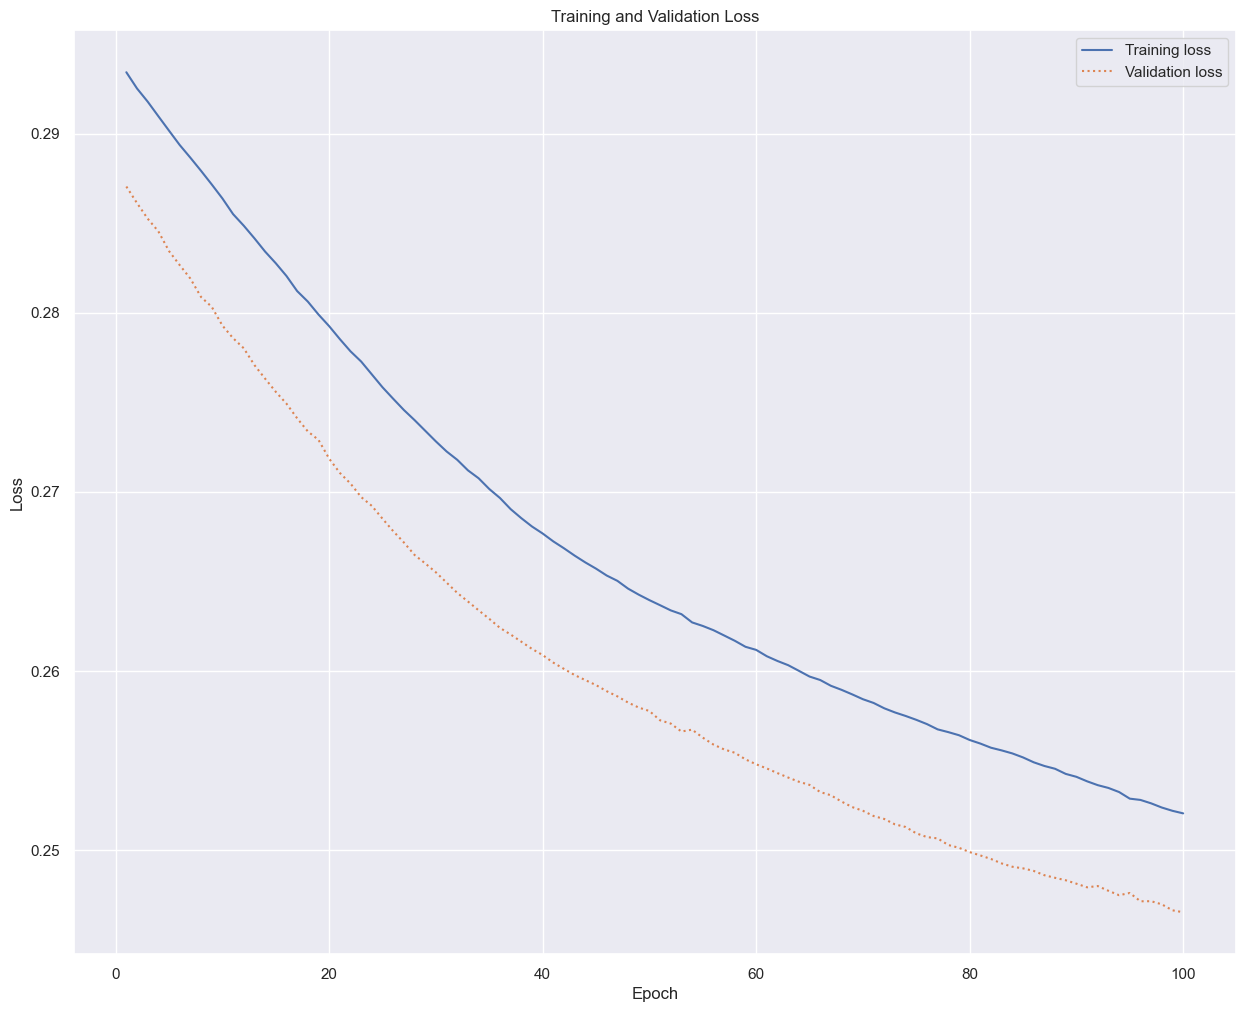

In [82]:
# Plotting validation accuracy vs training accuracy
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
# figure(figsize=(10,10))
plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.plot()

In [64]:
len(val_loss)

100

In [65]:
len(loss)

100

In [66]:
epochs

range(1, 51)

## Naive Bayes

In [36]:
class NaiveBayesClassifier:
    
    def __init__(self, threshold=10):
        self.threshold = threshold
        self.class_probs = {}
        self.feature_probs = {}
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        for c in self.classes:
            X_c = X[y == c]
            self.class_probs[c] = len(X_c) / n_samples
            
            for i in range(n_features):
                if i not in self.feature_probs:
                    self.feature_probs[i] = {}
                
                if len(np.unique(X[:,i])) <= self.threshold:
                    counts = Counter(X_c[:,i])
                    for value, count in counts.items():
                        self.feature_probs[i][(value, c)] = count / len(X_c)
                else:
                    mean = np.mean(X_c[:,i])
                    std = np.std(X_c[:,i])
                    self.feature_probs[i][c] = (mean, std)
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        y_pred = []
        for x in X:
            probs = {}
            for c in self.classes:
                class_prob = self.class_probs[c]
                feature_probs = self.feature_probs.copy()
                for i, value in enumerate(x):
                    if i in feature_probs:
                        if len(feature_probs[i]) <= self.threshold:
                            if (value, c) in feature_probs[i]:
                                feature_prob = feature_probs[i][(value, c)]
                            else:
                                feature_prob = 1e-6
                        else:
                            if c in feature_probs[i]:
                                mean, std = feature_probs[i][c]
                                feature_prob = self._gaussian_prob(value, mean, std)
                            else:
                                feature_prob = 1e-6
                        class_prob *= feature_prob
                probs[c] = class_prob
            y_pred.append(max(probs, key=probs.get))
        return y_pred
    
    def _gaussian_prob(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def score(self, X, y):
        pred = self.predict(X)
        return (pred == y).sum() / len(y)
    
    def evaluation(self, y_pred, y):
        y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
        tp = ((y_pred['y_pred'] == 1) & (y == 1)).sum()
        tn = ((y_pred['y_pred'] == 0) & (y == 0)).sum()
        fp = ((y_pred['y_pred'] == 1) & (y == 0)).sum()
        fn = ((y_pred['y_pred'] == 0) & (y == 1)).sum()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * tp / (2 * tp + fp + fn)
        return precision, recall, f1_score


In [37]:
clf = NaiveBayesClassifier(threshold=25)

In [38]:
clf.fit(X_train.values, y_train.values)

In [39]:
preds = clf.predict(X_train.values)

In [40]:
precision, recall, F1_score = clf.evaluation(preds, y_train.values)
print(f"Precision of the model is : {precision}\nRecall of the model is : {recall}\nF1_score of the model is : {F1_score}")

Precision of the model is : 0.3042168674698795
Recall of the model is : 0.06618610747051114
F1_score of the model is : 0.10871905274488698


In [41]:
clf.score(X_test.values, y_test.values)

0.8299877099549365

In [42]:
(np.array(clf.predict(X_train.values)) == True).sum()

332

In [43]:
y_train.value_counts()

0    8238
1    1526
Name: Revenue, dtype: int64

In [44]:
y_test.value_counts()

0    2059
1     382
Name: Revenue, dtype: int64

In [45]:
len(X_train.shape)

2

## Logistic Regression

In [65]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_liklihood(features, y, weights):
    scores = np.dot(features, weights)
    #f = -np.sum(((y*np.log(scores)) + ((1-y)*np.log(1-scores))))
    f = -np.sum(y*scores - np.log(1 + np.exp(scores)))
    return f

def gradient(features, y, yhat):
    """
    features: X
    y: actual response variable
    yhat: prediction (estimated) response variable
    """
    error = y - yhat
    df = np.dot(features.T, error)
    return df

def gradient_descent(features, y, yhat, alpha, weights):
    """repeatedly evaluating the gradient and then performing a parameter update"""    
    grad = gradient(features, y, yhat)
    weights += alpha * grad
    return weights

def logistic_regression(features, y, steps, alpha, add_intercept=False):
    """
    features: X
    y: acutal response
    steps: number of steps in gradient descent
    alphs: learning rate
    """
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    # initialize weights to zeroes
    weights = np.zeros(features.shape[1])
    log_error = []
    
    for step in range(steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)
        # update weights
        weights = gradient_descent(features, y, predictions, alpha, weights)
        
        # print log-liklihood
        #if step % 10000 == 0:
        #print(log_liklihood(features, y, weights))
        log_error.append(log_liklihood(features, y, weights))


    plt.plot(range(len(log_error)), log_error)
    plt.xlabel('No. of Iterations')
    plt.ylabel('Cost Function')
    plt.title('No. of Iterations vs Cost Function')
    plt.show()
            

    # print(log_error)       
    return weights



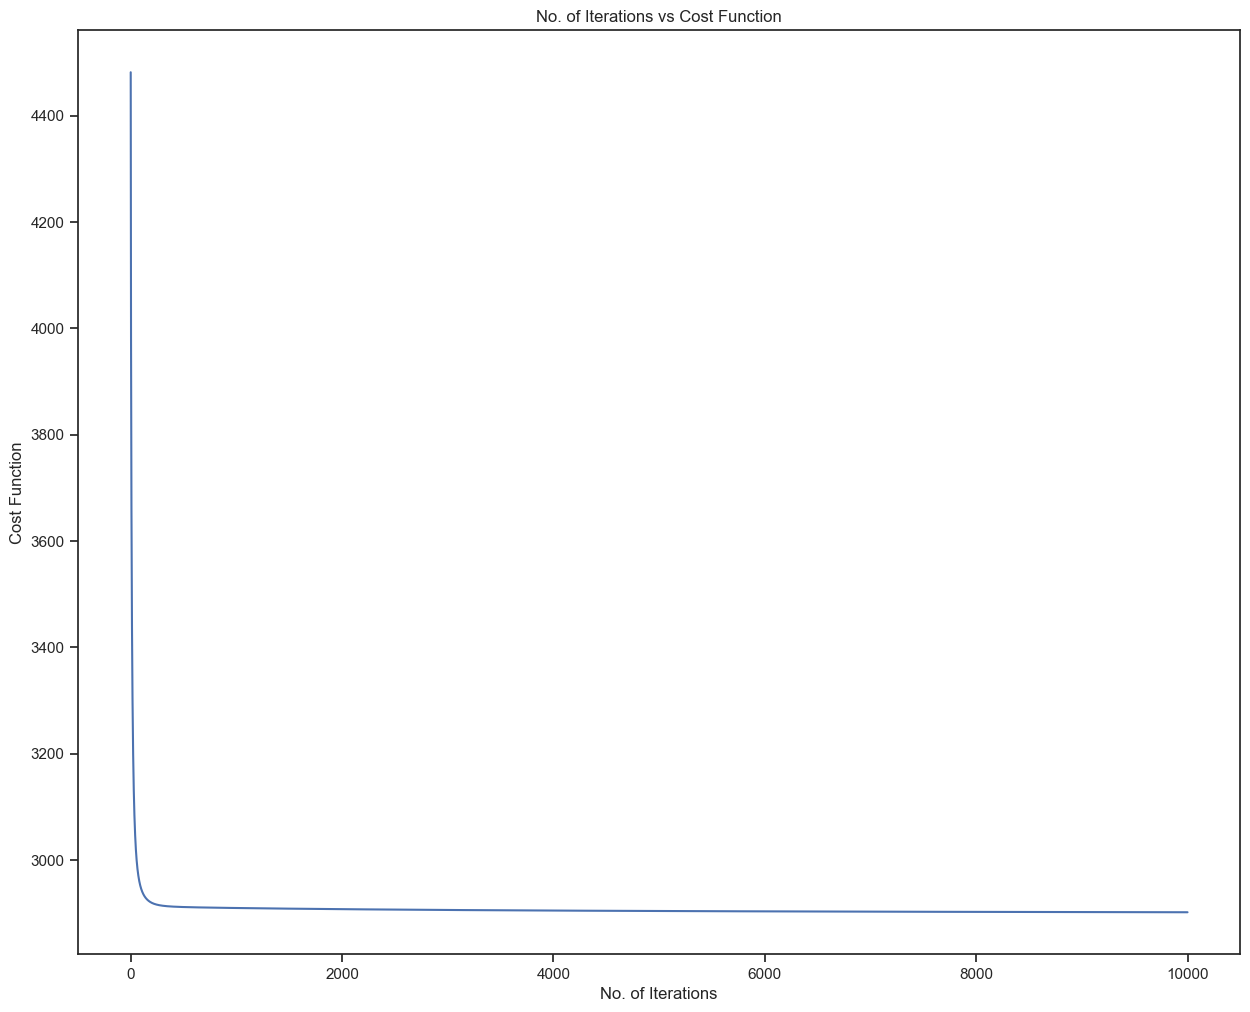

'Estimated regression coefficients: [-1.97014343e+00  5.00292783e-02 -8.52250505e-05 -6.74396318e-01\n  1.60191915e+00 -4.69182123e-02  2.22763994e-02  7.14074659e-02\n -6.90389589e-01 -1.68136016e+00 -4.36763590e-01 -5.95114812e-01\n -5.95917880e-01  4.77663825e-01 -2.05524457e-01 -9.47302258e-02\n  3.94518951e-01  2.30767744e-01 -4.78774994e-02]'

In [66]:
weights = logistic_regression(X_train, y_train.to_numpy().squeeze(), steps=10000, alpha=5e-5, add_intercept=True)
'Estimated regression coefficients: {}'.format(weights)

[[8041  197]
 [ 957  569]]


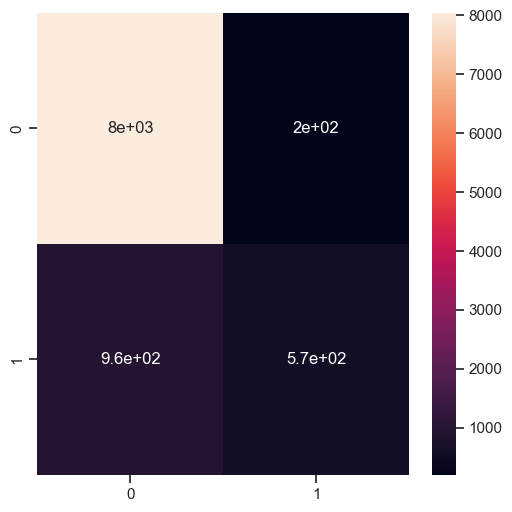

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      8238
           1       0.74      0.37      0.50      1526

    accuracy                           0.88      9764
   macro avg       0.82      0.67      0.71      9764
weighted avg       0.87      0.88      0.86      9764



In [67]:
from sklearn import metrics

final_scores = np.dot(np.hstack((np.ones((X_train.shape[0], 1)),X_train)), weights)

y_hat = np.round(sigmoid(final_scores))  # predictions

cnf_matrix = metrics.confusion_matrix(y_train.to_numpy().squeeze(), y_hat)
print(cnf_matrix)

#Plotting the confusion matrix

cm = metrics.confusion_matrix(y_train, y_hat)
plt.rcParams['figure.figsize'] = (6, 6)
sb.heatmap(cm, annot = True)
plt.show()

# import the metrics class


from sklearn.metrics import classification_report
print(classification_report(y_train.to_numpy().squeeze(), y_hat))

[[ 145 1914]
 [   0  382]]


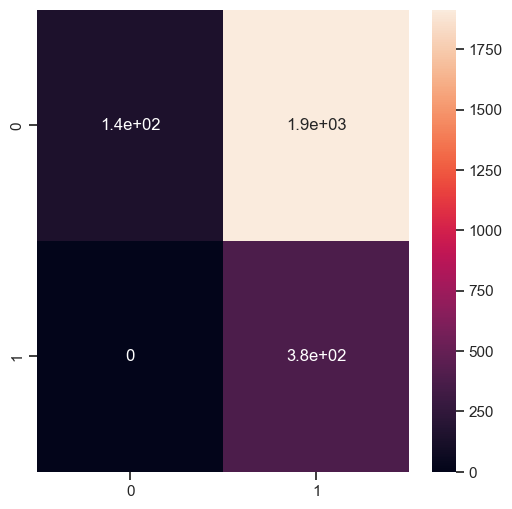

              precision    recall  f1-score   support

           0       1.00      0.07      0.13      2059
           1       0.17      1.00      0.29       382

    accuracy                           0.22      2441
   macro avg       0.58      0.54      0.21      2441
weighted avg       0.87      0.22      0.16      2441



In [68]:
final_scores = np.dot(np.hstack((np.ones((X_test.shape[0], 1)),X_test)), weights)

y_hat = np.round(sigmoid(final_scores))  # predictions

cnf_matrix = metrics.confusion_matrix(y_test.to_numpy().squeeze(), y_hat)
print(cnf_matrix)

#Plotting the confusion matrix

cm = metrics.confusion_matrix(y_test, y_hat)
plt.rcParams['figure.figsize'] = (6, 6)
sb.heatmap(cm, annot = True)
plt.show()

# import the metrics class


from sklearn.metrics import classification_report
print(classification_report(y_test.to_numpy().squeeze(), y_hat))

In [69]:
final_scores = np.dot(np.hstack((np.ones((X_test.shape[0], 1)),X_test)), weights)

y_hat = np.round(sigmoid(final_scores))  # predictions

cnf_matrix = metrics.confusion_matrix(y_test.to_numpy().squeeze(), y_hat)
print(cnf_matrix)

# import the metrics class


from sklearn.metrics import classification_report
print(classification_report(y_test.to_numpy().squeeze(), y_hat))

[[ 145 1914]
 [   0  382]]
              precision    recall  f1-score   support

           0       1.00      0.07      0.13      2059
           1       0.17      1.00      0.29       382

    accuracy                           0.22      2441
   macro avg       0.58      0.54      0.21      2441
weighted avg       0.87      0.22      0.16      2441

